In [2]:
using Distributed
# addprocs(8);

In [3]:
using ProgressMeter
using Statistics
using PyPlot
using JLD2
using PyCall
using DelimitedFiles

In [5]:
@everywhere using PyCall

@everywhere begin
    
    using PyCall
    using CMBLensing
    
    lmax = 5000

    py"""

    import sys
    sys.path.append("/home/marius/src/cmblensing/cmblensing/")
    import os
    import cmblensing

    datadir = "/home/marius/src/cmblensing/test/test_calc_clbb/inputs/wmap7_lcdm/bestfit_"
    lmax = $lmax

    cl_unl = cmblensing.spec.camb_clfile(datadir+'scalCls.dat',lmax=lmax)
    cl_len = cmblensing.spec.camb_clfile(datadir+'lensedCls.dat',lmax=lmax)
    cl_bb_lens = cmblensing.calc_clbb(lmax, cl_unl.clee, cl_unl.clpp)

    def get_nl_phi_eb_iter(l, nl_bb, nl_ee):
        '''
        Returns the lensing reconstruction noise, N^{\phi \phi}, for
        an iterative EB estimator.
        From Eq's 18 and 19 of 1010.0048.
        '''
        cl_bb_res = cl_bb_lens.copy()
        max_frac_diff = 99.
        counter = 0
        while (max_frac_diff>0.01):
            counter += 1
            last_cl_bb_res = cl_bb_res
            nl_phiphi_eb = cmblensing.calc_nlpp(lmax, cl_bb_res, cl_unl.clee, nl_bb)
            cl_bb_res = get_clbb_res(cl_bb_lens, nl_ee, nl_phiphi_eb)
            max_frac_diff =np.max(np.abs((cl_bb_res-last_cl_bb_res)/last_cl_bb_res)[50:])
        return (nl_phiphi_eb, cl_bb_res)

    def get_clbb_res(clbb, nl_ee, nl_phiphi):
        '''
        Returns the residual C^{BB} power after delensing.
        CLBB is the original lensed B-mode power C^{BB}.
        From Eq 12 of 1010.0048.
        '''
        return clbb - cmblensing.calc_clbb(lmax,cl_unl.clee**2./(cl_unl.clee+nl_ee),(cl_unl.clpp)**2./(cl_unl.clpp+nl_phiphi))

    from pylab import *
    nlpp = array([deg2rad(1./60)**2]*(lmax+1));

    """

    AL_res(;μKarcminT,beamFWHM) = mean((py"get_nl_phi_eb_iter"(0:lmax, fill(noisecls(ΔP/√2, beamFWHM=beamFWHM)[:EE][2:lmax+2],2)...)[2] ./ py"cl_bb_lens")[3:200]);
    
end

In [6]:
ΔPs       = range(0.1, 4, length=20)
beamFWHMs = range(1,   6, length=11);

In [ ]:
ALs = @showprogress pmap(tuple.(ΔPs', beamFWHMs)) do (ΔP,beamFWHM)
    AL_res(ΔP,beamFWHM)
end;

In [219]:
# @save "ALs.jld2" ALs ΔPs beamFWHMs
# writedlm("ALs.txt",ALs)
# writedlm("DeltaPs.txt",ΔPs)
# writedlm("beamFWHMs.txt",beamFWHMs)

In [4]:
@load "ALs.jld2" ALs ΔPs beamFWHMs

3-element Array{Symbol,1}:
 :ALs      
 :ΔPs      
 :beamFWHMs

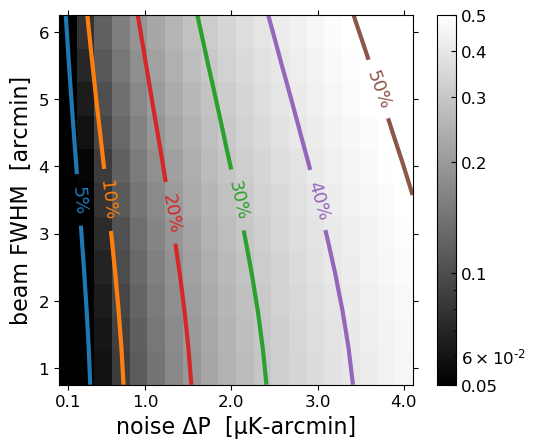

In [11]:
extent=((extrema(ΔPs) .+ [-1, 1] .* diff(ΔPs)[1]/2)..., (extrema(beamFWHMs) .+ [-1, 1] .* diff(beamFWHMs)[1]/2)...)
aspect=-(extrema(ΔPs)...) / -(extrema(beamFWHMs)...)

imshow(ALs[end:-1:1,:], aspect=aspect, vmin=0.05, vmax=0.5, cmap="gray", extent=extent, norm=pyimport("matplotlib.colors").LogNorm(vmin=0.049, vmax=0.4),)
cbar = colorbar(ticks=[0.05,0.1,0.2,0.3,0.4,0.5])
cbar.ax.set_yticklabels([0.05,0.1,0.2,0.3,0.4,0.5])

    
cs = contour(ALs, levels=[0.05,0.10,0.2,0.3,0.4,0.5], "k", linewidths=3, extent=extent, colors=["C$(i-1)" for i=[1,2,4,3,5,6]], )
clabel(cs, inline=true, fmt=Dict([0.05=>"5%", 0.10=>"10%", 0.2=>"20%", 0.3=>"30%", 0.4=>"40%", 0.5=>"50%"]), fontsize=13, inline_spacing=15)

tick_params(direction="out")
yticks(1:6)
xticks([0.1; 1:4])
ylabel("beam FWHM  [arcmin]")
xlabel("noise ΔP  [μK-arcmin]");

# plot(0.68, 2.3, "x", c="w", markeredgewidth=2, markersize=8)
# plot(0.96, 1.5, "x", c="w", markeredgewidth=2, markersize=8)

savefig("AL_residual.pdf", bbox_inches="tight")

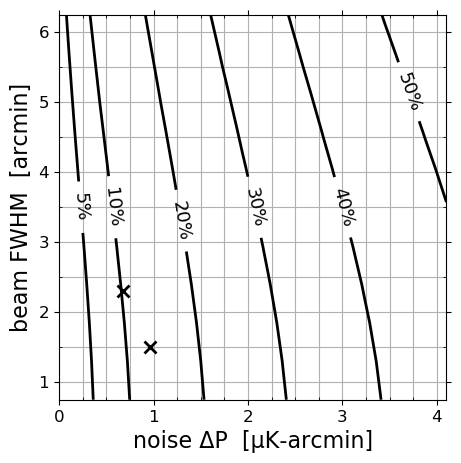

In [8]:
figure(figsize=(5,5))

extent=((extrema(ΔPs) .+ [-1, 1] .* diff(ΔPs)[1]/2)..., (extrema(beamFWHMs) .+ [-1, 1] .* diff(beamFWHMs)[1]/2)...)
aspect=-(extrema(ΔPs)...) / -(extrema(beamFWHMs)...)

# imshow(ALs, aspect=aspect, vmin=0, vmax=0.4, cmap="gray", extent=extent)
# colorbar()
# cs = contour(ALs, levels=[0.05,0.10,0.2,0.3,0.4,0.5], linewidths=3, extent=extent, colors=["C$(i-1)" for i=1:6], )
cs = contour(ALs, levels=[0.05,0.10,0.2,0.3,0.4,0.5], linewidths=2, extent=extent, colors="k")


clabel(cs, inline=true, fmt=Dict([0.05=>"5%", 0.10=>"10%", 0.2=>"20%", 0.3=>"30%", 0.4=>"40%", 0.5=>"50%"]), fontsize=13, inline_spacing=15)

tick_params(direction="out")
yticks(1:6)

gca().set_xticks(0:0.25:4, minor=true)
gca().set_yticks(1:0.5:6, minor=true)
grid(which="both")

xticks([0; 1:4])
ylabel("beam FWHM  [arcmin]")
xlabel("noise ΔP  [μK-arcmin]");

plot(0.68, 2.3, "x", c="k", markeredgewidth=2, markersize=8)
plot(0.96, 1.5, "x", c="k", markeredgewidth=2, markersize=8)

savefig("AL_residual.pdf", bbox_inches="tight")